In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import csv
data = pd.read_csv("/content/News.csv", quoting=csv.QUOTE_NONE, on_bad_lines='skip')

<ipython-input-80-ddfac52873a7>:2: DtypeWarning: Columns (0,45) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/News.csv", quoting=csv.QUOTE_NONE, on_bad_lines='skip')


In [ ]:
data = pd.read_csv('News.csv',index_col=0)
data.head()








,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
data.shape

(44919, 5)

In [ ]:
data = data.drop(["title", "subject","date"], axis = 1)

In [ ]:
data.isnull().sum()

,0
text,0
class,0


In [ ]:
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

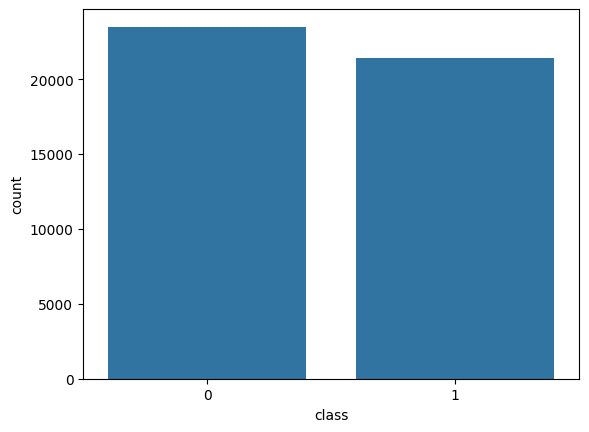

In [ ]:
sns.countplot(data=data,
			x='class',
			order=data['class'].value_counts().index)

In [ ]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text

In [ ]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [34:12<00:00, 21.88it/s]


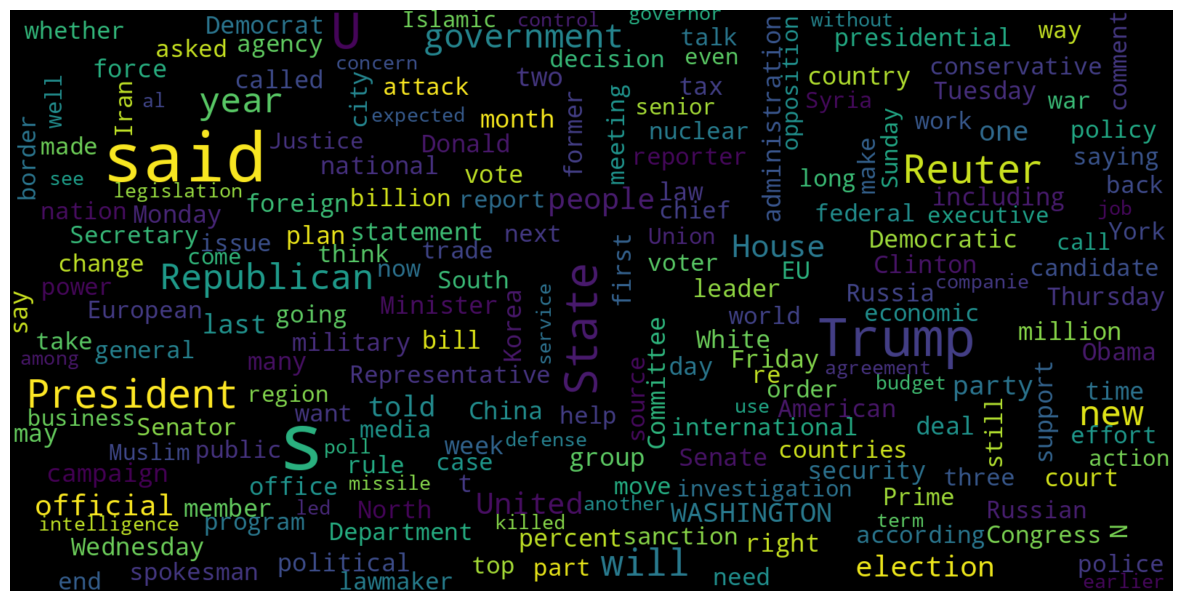

In [ ]:
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

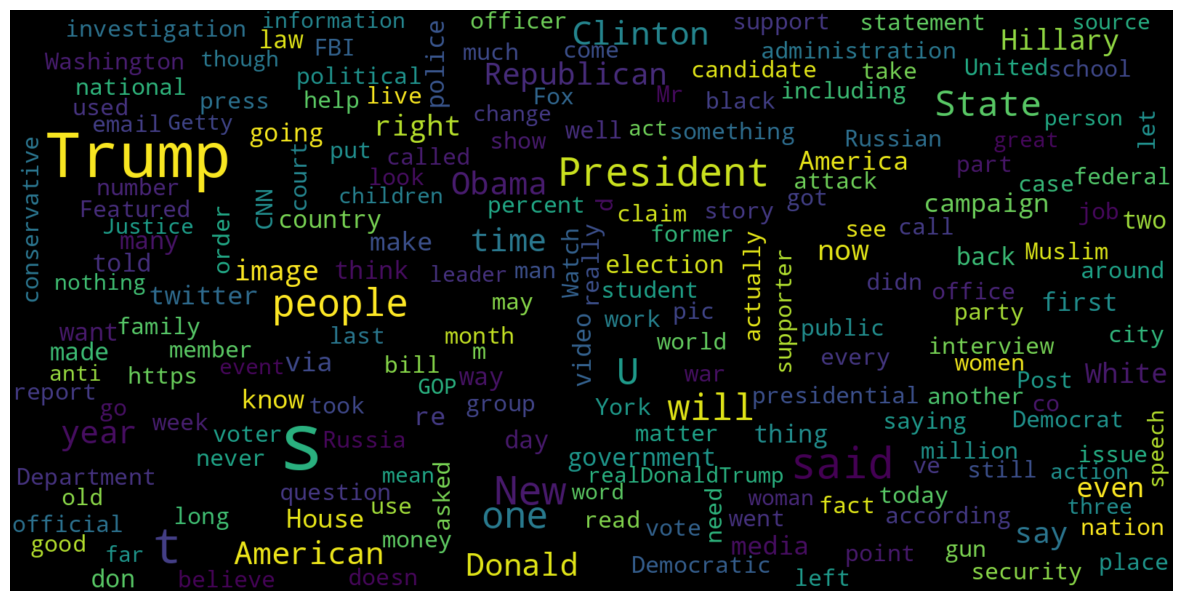

In [ ]:
# Fake
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

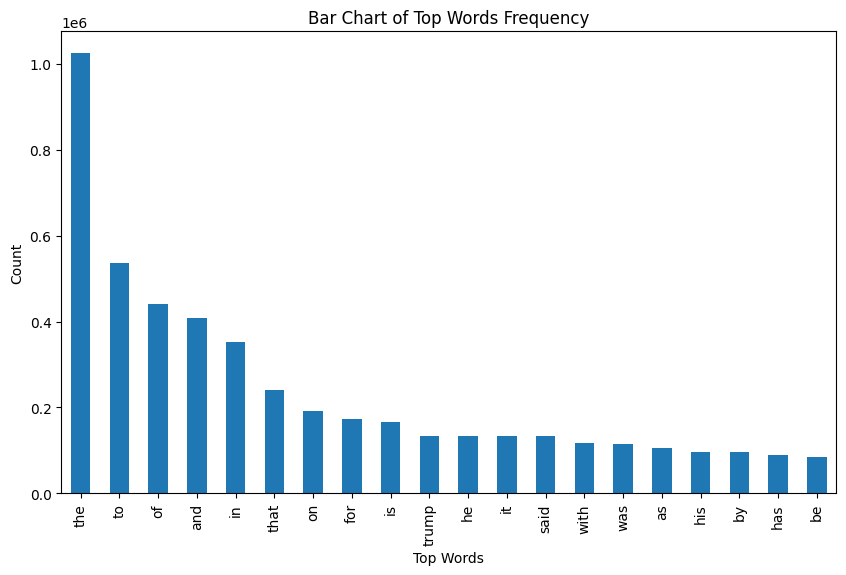

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
	vec = CountVectorizer().fit(corpus)
	bag_of_words = vec.transform(corpus)
	sum_words = bag_of_words.sum(axis=0)
	words_freq = [(word, sum_words[0, idx])
				for word, idx in vec.vocabulary_.items()]
	words_freq = sorted(words_freq, key=lambda x: x[1],
						reverse=True)
	return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
	kind='bar',
	figsize=(10, 6),
	xlabel="Top Words",
	ylabel="Count",
	title="Bar Chart of Top Words Frequency"
)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


x_train, x_test, y_train, y_test = train_test_split(data['text'],
													data['class'],
													test_size=0.25)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)


print(accuracy_score(y_test, model.predict(x_test)))

0.994033837934105


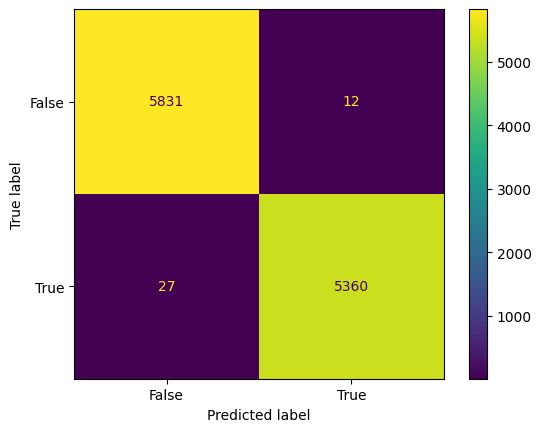

In [ ]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()

In [ ]:
import os
import re
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download stopwords if not already done
nltk.download('stopwords')
nltk.download('punkt')

# Define stopwords
stop_words = set(stopwords.words('english'))

def preprocess_single_input(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and convert to lowercase
    tokens = [word for word in text.split() if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

def predict_fake_news(input_text):
    processed_text = preprocess_single_input(input_text)
    input_vector = vectorization.transform([processed_text])  # Assuming vectorization is defined
    prediction = model.predict(input_vector)  # Assuming model is defined
    return "Fake News" if prediction[0] == 0 else "Real News"


user_input = input("Enter the news headline or article text: ")
try:
    result = predict_fake_news(user_input)
    print(f"The model predicts: {result}")
except NameError as e:
    print(f"Error: {e}. Ensure that 'vectorization' and 'model' are properly defined and loaded.")




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Enter the news headline or article text: WEST PALM BEACH, Fla (Reuters) - President Donald Trump said on Thursday he believes he will be fairly treated in a special counsel investigation into Russian meddling in the U.S. presidential election, but said he did not know how long the probe would last. The federal investigation has hung over Trumpâ€™s White House since he took office almost a year ago, and some Trump allies have in recent weeks accused the team of Justice Department Special Counsel Robert Mueller of being biased against the Republican president. But in an interview with the New York Times, Trump appeared to shrug off concerns about the investigation, which was prompted by U.S. intelligence agenciesâ€™ conclusion that Russia tried to help Trump defeat Democrat Hillary Clinton by hacking and releasing embarrassing emails and disseminating propaganda. â€œThereâ€™s been no collusion. But I think heâ€™s going to be fair,â€ Trump said in what the Times described as a 30-minute 